<a href="https://colab.research.google.com/github/imakhxl/Titanic-Survival-Prediction/blob/main/TitanicSurvivalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Titanic Survival Prediction

The primary objective of this project is to develop a machine learning model capable of predicting the survival status of Titanic passengers based on available data. The dataset includes information such as demographic attributes (age, sex), socioeconomic status (fare, class), and other relevant features. By analyzing these features, we seek to identify patterns that could influence survival rates and subsequently use these insights to make predictions on unseen data.

In [114]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')  # For better visualization style
%matplotlib inline
warnings.filterwarnings('ignore')  # To ignore warning messages

In [115]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [116]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [117]:
train.shape

(891, 12)

In [118]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [119]:
train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


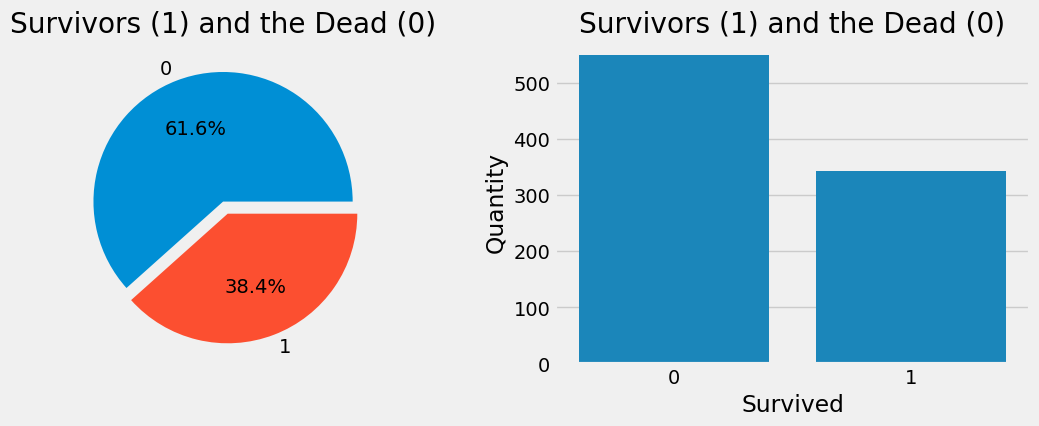

In [120]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train['Survived'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=False)
ax[0].set_title('Survivors (1) and the Dead (0)')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors (1) and the Dead (0)')
plt.show()


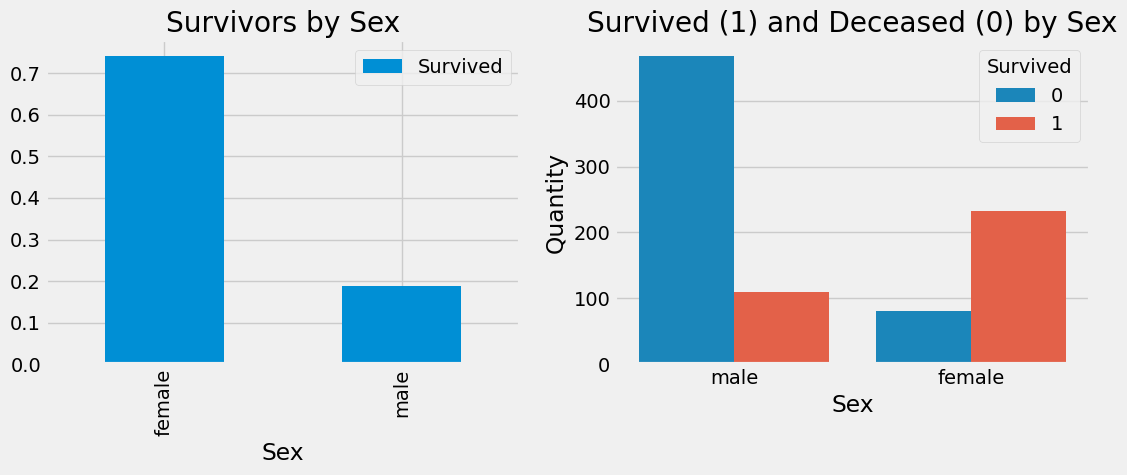

In [121]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survivors by Sex')
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survived (1) and Deceased (0) by Sex')
plt.show()

**Feature Engineering**

Dropping redundant features

In [122]:
train = train.drop(['Cabin', 'Ticket'], axis=1)
test = test.drop(['Cabin', 'Ticket'], axis=1)

There are many missing features in "Embarked", so we fill the missing values with most common value "S"

In [123]:
train = train.fillna({"Embarked": "S"})

In [124]:
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf] #bins are (-1,0), (0,5), (5,12)...
labels = ['Unknown', 'Baby', 'Child', 'Teenager',
          'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels) #new column "AgeGroup", with new classifications for Age
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)


In [125]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Young Adult


In [126]:
# create a combined group of both datasets
combine = [train, test]

# extract a title for each Name in the
# train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [127]:
# replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major',
                                                 'Rev', 'Jonkheer', 'Dona'],
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace(
        ['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [128]:
# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [129]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()


,Title,Survived
0,1,0.156673
1,2,0.702703
2,3,0.793651
3,4,0.575000
4,5,1.000000
5,6,0.285714


In [130]:
dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,Young Adult,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,Adult,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,Senior,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,Young Adult,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,Student,3


In [131]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode()  # Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode()  # Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode()  # Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode()  # Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode()  # Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode()  # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
                     3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]


In [132]:
# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
               'Student': 4, 'Young Adult': 5, 'Adult': 6,
               'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,4.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,6.0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,5.0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,5.0,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,5.0,1


In [133]:
# dropping the Age feature for now, might change, also name
train = train.drop(['Age','Name'], axis=1)
test = test.drop(['Age','Name'], axis=1)

In [134]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)


In [135]:
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x]  # Pclass = 3
        test["Fare"][x] = round(
            train[train["Pclass"] == pclass]["Fare"].mean(), 4)

# map Fare values into groups of
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4,
                            labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4,
                           labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)

**Model Training**

In [136]:
from sklearn.model_selection import train_test_split

# Drop the Survived and PassengerId
# column from the trainset
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(
    predictors, target, test_size=0.2, random_state=0)

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

# Fit the training data along with its output
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

# Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

83.24


Evaluation

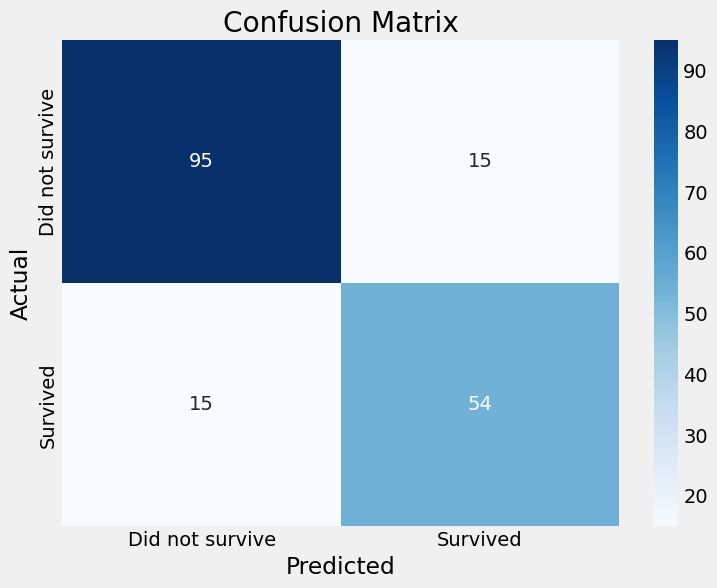

In [138]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Did not survive", "Survived"],
            yticklabels=["Did not survive", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [139]:
# Generate and print the classification report
class_report = classification_report(y_val, y_pred, target_names=["Did not survive", "Survived"])
print("Classification Report:\n", class_report)

Classification Report:
                  precision    recall  f1-score   support

Did not survive       0.86      0.86      0.86       110
       Survived       0.78      0.78      0.78        69

       accuracy                           0.83       179
      macro avg       0.82      0.82      0.82       179
   weighted avg       0.83      0.83      0.83       179



Use the model on test dataset

In [140]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

# set the output as a dataframe and convert
# to csv file named resultfile.csv
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})
output.to_csv('resultfile.csv', index=False)

In [141]:
# Load the CSV file
result = pd.read_csv('resultfile.csv')

# Display the first few rows
print(result.head())

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         0
